In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

import joblib

###Importando dados

In [6]:
#importando os dados
data = pd.read_csv("desafio_indicium_imdb.csv", index_col = 0)
data.head()

,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
1,The Godfather,1972,A,175 min,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,"134,966,411"
2,The Dark Knight,2008,UA,152 min,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,"534,858,444"
3,The Godfather: Part II,1974,A,202 min,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,"57,300,000"
4,12 Angry Men,1957,U,96 min,"Crime, Drama",9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,"4,360,000"
5,The Lord of the Rings: The Return of the King,2003,U,201 min,"Action, Adventure, Drama",8.9,Gandalf and Aragorn lead the World of Men agai...,94.0,Peter Jackson,Elijah Wood,Viggo Mortensen,Ian McKellen,Orlando Bloom,1642758,"377,845,905"


In [7]:
#Passar variáveis de string para float

data['Runtime'] = data['Runtime'].str.replace(' min', '').astype(float)
data['No_of_Votes'] = data['No_of_Votes'].astype(float)
data['Gross'] = data['Gross'].str.replace(',','').astype(float)

Quando fui mudar o tipo da coluna dos anos de lançamento (Released_Year), percebi um erro em que um dos valores não era um ano e sim a classificação. Para isso busquei a coluna no dataframe e mudei o valor pelo ano que busquei direto no site da IMDb.

In [8]:
linhas_invalidas = data[~data['Released_Year'].astype(str).str.match(r"^\d{4}$", na=False)]
linhas_invalidas

,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
966,Apollo 13,PG,U,140.0,"Adventure, Drama, History",7.6,NASA must devise a strategy to return Apollo 1...,77.0,Ron Howard,Tom Hanks,Bill Paxton,Kevin Bacon,Gary Sinise,269197.0,173837933.0


In [9]:
data.loc[linhas_invalidas.index, 'Released_Year'] = "1995"
data['Released_Year'][linhas_invalidas.index]

,Released_Year
966,1995


In [10]:
data['Released_Year'] = data['Released_Year'].astype(float)

# Análise estatística e EDA

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 999 entries, 1 to 999
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Series_Title   999 non-null    object 
 1   Released_Year  999 non-null    float64
 2   Certificate    898 non-null    object 
 3   Runtime        999 non-null    float64
 4   Genre          999 non-null    object 
 5   IMDB_Rating    999 non-null    float64
 6   Overview       999 non-null    object 
 7   Meta_score     842 non-null    float64
 8   Director       999 non-null    object 
 9   Star1          999 non-null    object 
 10  Star2          999 non-null    object 
 11  Star3          999 non-null    object 
 12  Star4          999 non-null    object 
 13  No_of_Votes    999 non-null    float64
 14  Gross          830 non-null    float64
dtypes: float64(6), object(9)
memory usage: 157.2+ KB


In [12]:
data.describe()

,Released_Year,Runtime,IMDB_Rating,Meta_score,No_of_Votes,Gross
count,999.000000,999.000000,999.000000,842.000000,9.990000e+02,8.300000e+02
mean,1991.218218,122.871872,7.947948,77.969121,2.716214e+05,6.808257e+07
std,23.297166,28.101227,0.272290,12.383257,3.209126e+05,1.098076e+08
min,1920.000000,45.000000,7.600000,28.000000,2.508800e+04,1.305000e+03
25%,1976.000000,103.000000,7.700000,70.000000,5.547150e+04,3.245338e+06
50%,1999.000000,119.000000,7.900000,79.000000,1.383560e+05,2.345744e+07
75%,2009.000000,137.000000,8.100000,87.000000,3.731675e+05,8.087634e+07
max,2020.000000,321.000000,9.200000,100.000000,2.303232e+06,9.366622e+08


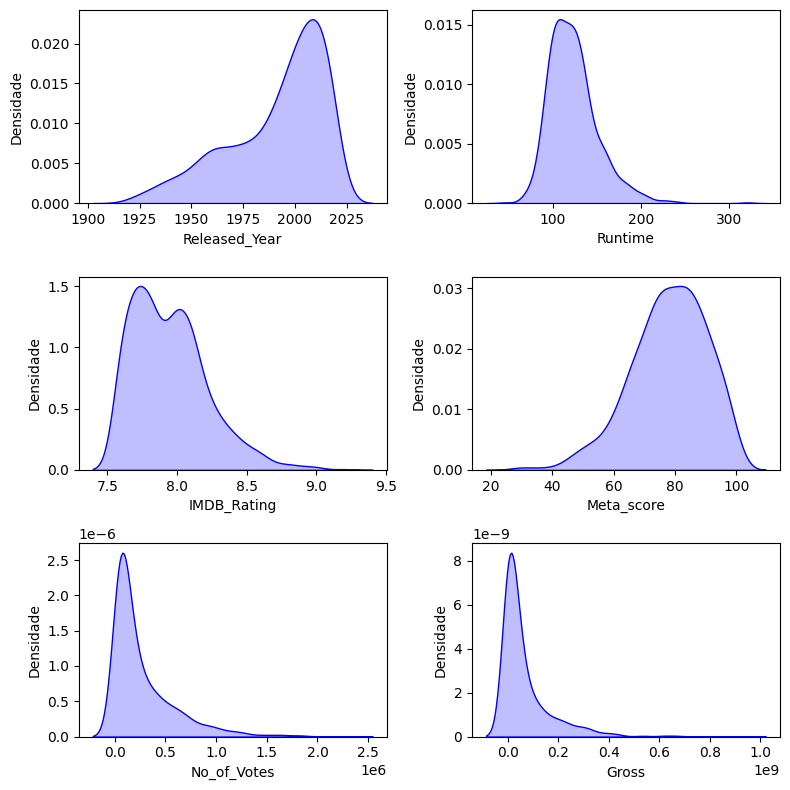

In [13]:
#KDE
data_num = data.select_dtypes(include=np.number).columns #selecionando as colunas com valores numéricos

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(8,8))
axes = axes.flatten()

for i, col in enumerate(data_num):
    sns.kdeplot(x=data[col], fill=True, ax=axes[i], color='b')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Densidade')

plt.tight_layout()
plt.show()



*   **Released_Year**: base de dados recente com a maioria dos filmes concentrados entre 2000 e 2025
*   **Runtime**: A maior parte dos filmes tem duração padrão de filmes comerciais (em torno de 120 min)
*   **IMDB_Rating**: A maior parte dos filmes apresenta boas avaliações com notas médias as altas.
*   **Meta_score**: A métrica segue o padrão de notas do IMDB, porém com menos extremidades.
*   **No_of_Votes**:Poucos filmes recebem milhões de avaliações e provavelmente esses são filmes muito populares como blockbusters.
*   **Gross**: Poucos filmes tem faturamentos gigantescos, o que pode indicar uma monipolização do mercado de filmes por algumas produtoras específicas.




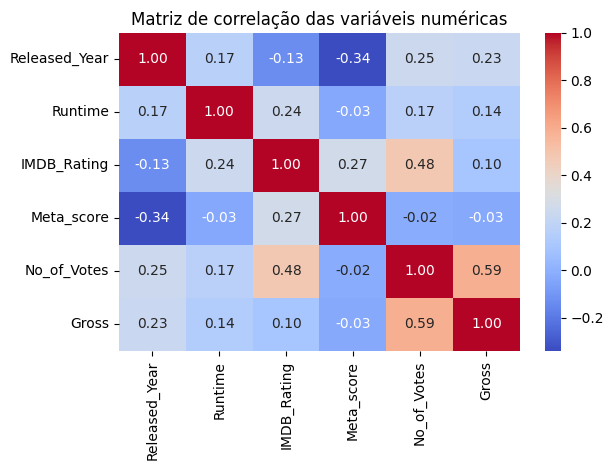

In [14]:
#Gráfico de correlação das variáveis
corr = data[data_num].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de correlação das variáveis numéricas")
plt.tight_layout()
plt.show()

* O gráfico mostra uma relação positiva entre o número de votos e o faturmento (0.59), podendo indicar que filmes populares lucram mais.
* A relação entre a nota do IMBD com a dos criticos também é positiva, apesar de menor, e pode indicar que não necessáriamente filmes populares são bem aclamados pela crítica e ganham premiassões, porém há uma concordância parcial entre o público e a crítica.
*A relação entre a duração do filme e as notas do público IMDB é positiva e apesar da correlação moderada pode indicar que filmes curtos não são tão bem aceitos pelo público.

##Análise com o faturamento

In [15]:
data_num_wo_gross = data_num.drop('Gross') #lista de dados numérica sem o faturamento
data_num_wo_gross

Index(['Released_Year', 'Runtime', 'IMDB_Rating', 'Meta_score', 'No_of_Votes'], dtype='object')

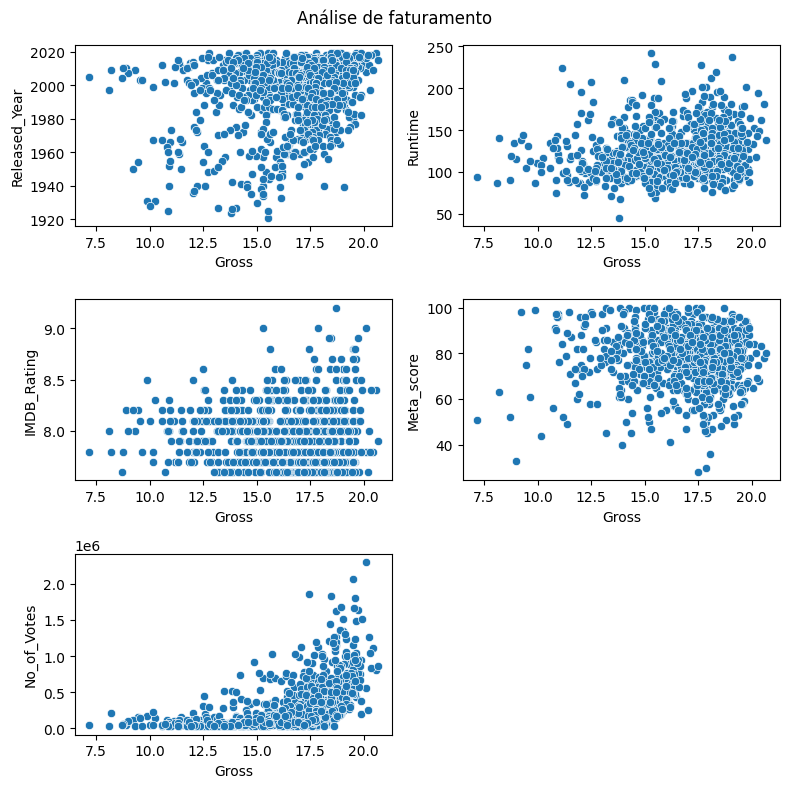

In [21]:
log_gross = np.log1p(data['Gross']) #para resolver o problema de assimetria

num_colunas = len(data_num_wo_gross)
ncols_ = 2
nrows_ = math.ceil(num_colunas / ncols_)
fig, axes = plt.subplots(nrows=nrows_, ncols=ncols_, figsize=(8,8))
axes = axes.flatten()

for i, col in enumerate(data_num_wo_gross):
    sns.scatterplot(x=log_gross, y= data[col], ax=axes[i])
    axes[i].set_xlabel("Gross")
    axes[i].set_ylabel(col)

for j in range(num_colunas, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Análise de faturamento")
plt.tight_layout()
plt.show()

Os gráficos mostram que filmes com maior nota, tanto do público IMDB quanto da crítica, não necessáriamente apresentam os maiores faturamentos. Porém há uma grande relação entre popularidade (número de votos) e faturamento, o que pode indicar há necessidade de uma boa campanha de marketing para o filme produzido

##Análise variáveis categóricas

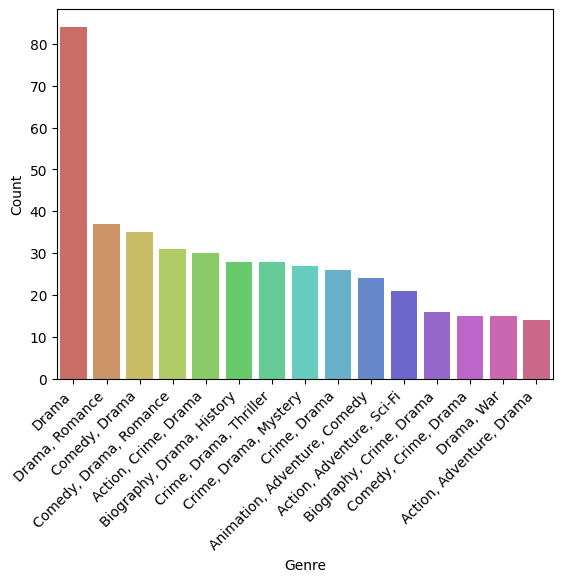

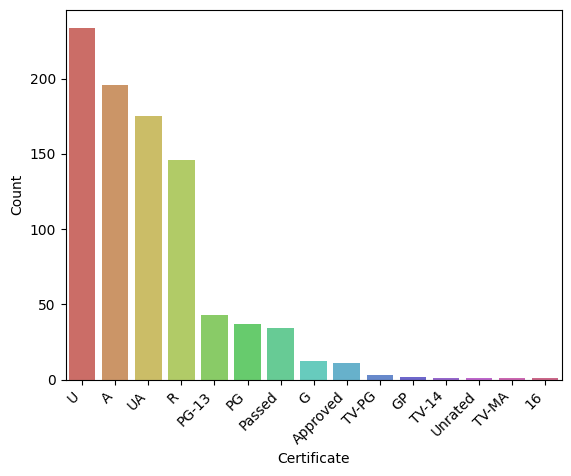

In [20]:
aux = ['Genre', 'Certificate']

for i, col in enumerate(aux):
  top15 = data[col].value_counts().head(15).reset_index()
  top15.columns = [col, 'Count']
  palette = sns.color_palette("hls", len(top15))
  ax = sns.barplot(x=col, y='Count', data=top15, hue = col, palette=palette, legend= False)
  plt.xlabel(col)
  plt.ylabel("Count")
  plt.xticks(rotation=45, ha='right')
  plt.tight_layout
  plt.show()

###Overview

In [23]:
from wordcloud import WordCloud

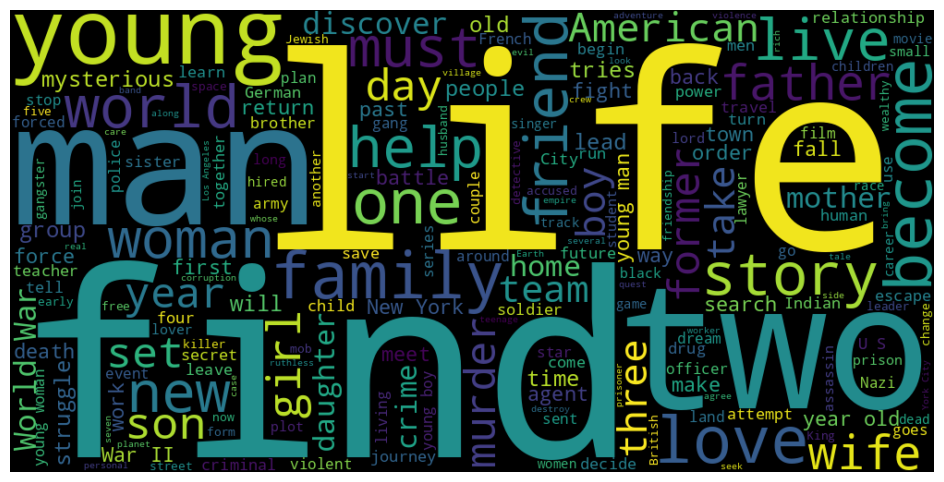

In [24]:
text = " ".join(data["Overview"].dropna().astype(str).tolist())

wordcloud = WordCloud(width=1000, height=500, background_color="black").generate(text)
plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

###Análise diretores e artistas

In [60]:
limiar = 8.0  #filmes com notas boas acima de 8.0
data_bons = data[data["IMDB_Rating"] >= limiar]

top10_diretores = (
    data_bons.groupby("Director")["IMDB_Rating"].agg(["count", "mean"])
    .sort_values(by="count", ascending=False).head(10)
)

print("Top 10 diretores")
print(top10_diretores)
print('/////////////////////////////////////////')


top10_star1 = (
    data_bons.groupby("Star1")["IMDB_Rating"].agg(["count", "mean"]).sort_values(by="count", ascending=False).head(10)
)

print("\n Top 10 Star 1")
print(top10_star1)
print('///////////////////////////////////////////')

top10_star2= (
    data_bons.groupby("Star2")["IMDB_Rating"].agg(["count", "mean"]).sort_values(by="count", ascending=False).head(10)
)

print("\n Top 10 Star2")
print(top10_star2)
print('//////////////////////////////////////////////')

Top 10 diretores
                   count      mean
Director                          
Akira Kurosawa        10  8.220000
Stanley Kubrick        8  8.275000
Steven Spielberg       7  8.328571
Christopher Nolan      7  8.557143
Alfred Hitchcock       7  8.257143
Martin Scorsese        7  8.328571
Ingmar Bergman         7  8.142857
Billy Wilder           7  8.242857
Charles Chaplin        6  8.333333
Hayao Miyazaki         6  8.250000
/////////////////////////////////////////

 Top 10 Star 1
                   count      mean
Star1                             
Toshirô Mifune         7  8.242857
James Stewart          7  8.214286
Leonardo DiCaprio      7  8.257143
Aamir Khan             7  8.214286
Robert De Niro         6  8.316667
Charles Chaplin        6  8.333333
Tom Hanks              5  8.500000
Clint Eastwood         5  8.280000
Al Pacino              5  8.300000
Humphrey Bogart        4  8.175000
///////////////////////////////////////////

 Top 10 Star2
                  count   

##Análise FaturamentoxGêneroXIMDB_Rating

In [26]:
#condensação de generos para uma melhor análise
data_ = data
data_["Genre_main"] = data["Genre"].str.split(",").str[0].str.strip()


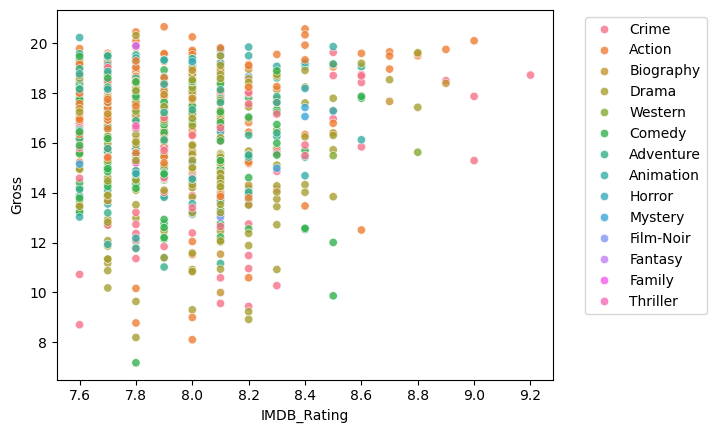

In [27]:
#relação genero x faturamento x nota
sns.scatterplot(x=data_["IMDB_Rating"],y=log_gross, hue=data_["Genre_main"], alpha=0.8)

plt.xlabel("IMDB_Rating")
plt.ylabel("Gross")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

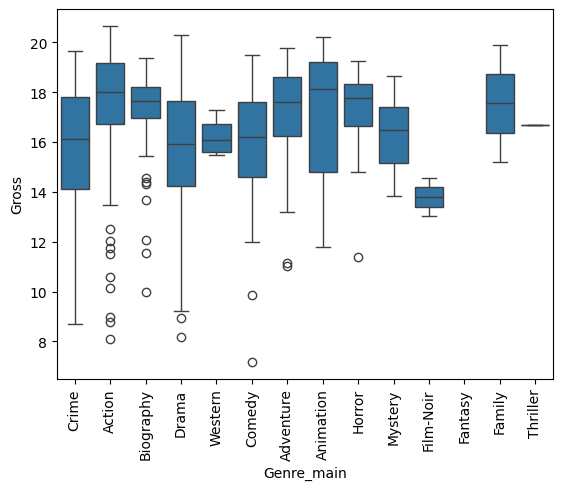

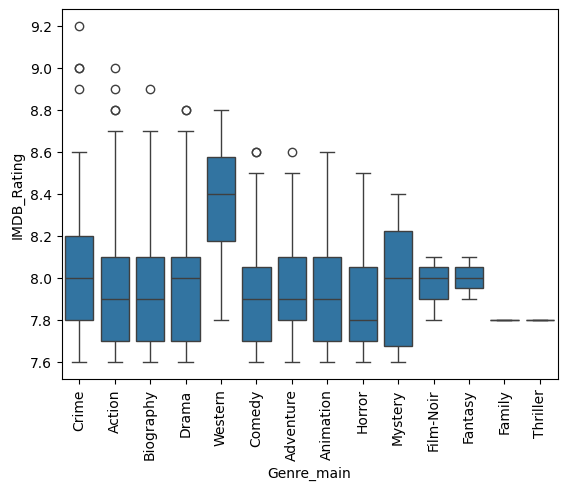

In [35]:
sns.boxplot(x="Genre_main", y=log_gross, data=data_)
plt.xticks(rotation=90)
plt.show()

sns.boxplot(x="Genre_main", y='IMDB_Rating', data=data_)
plt.xticks(rotation=90)
plt.show()

* **IMDB Rating x Gênero**: Western apresenta uma das melhores notas porém por outras análises sabemos que não é um genêro muito popular, então não tem um grande faturamento. Dama, Crime e Action, são genêros populares com boa avaliações mas uma variação ampla.
* **Faturamento x Gênero**: Action e Adventure apresentam bom faturamento e são genêros populares e bem avaliados, com um padrão de sucesso continúo. Animation também apresenta um bom faturamento, provavelmente pois geramente são voltados ao público infantil.

##Análise das relações com IMBD_Rating

In [36]:
data_num_wo_IMDB = data_num.drop('IMDB_Rating') #lista de dados numérica sem o faturamento
data_num_wo_IMDB

Index(['Released_Year', 'Runtime', 'Meta_score', 'No_of_Votes', 'Gross'], dtype='object')

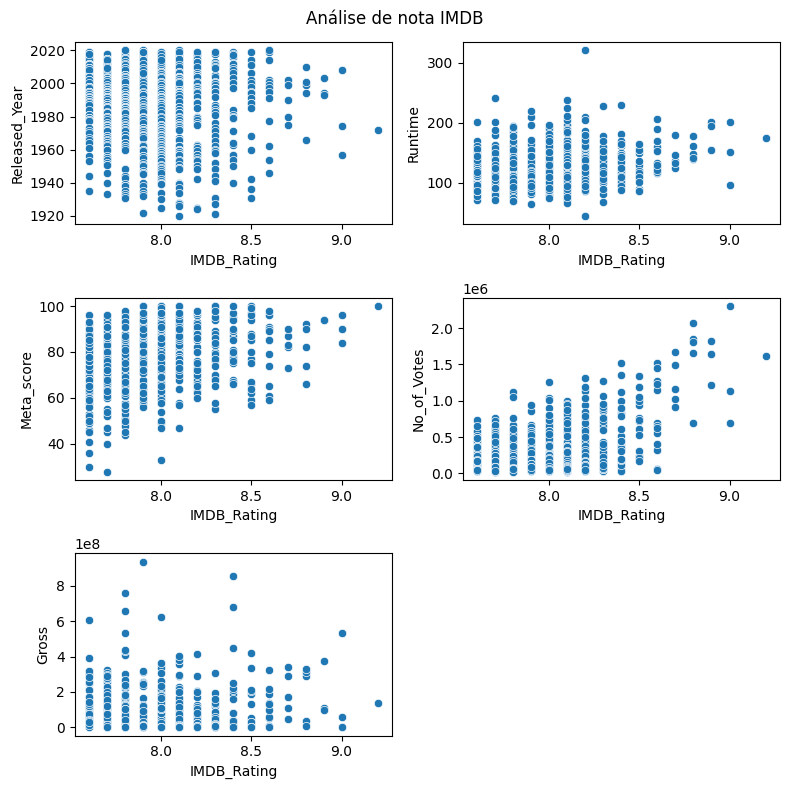

In [37]:
num_colunas = len(data_num_wo_IMDB)
ncols_ = 2
nrows_ = math.ceil(num_colunas / ncols_)
fig, axes = plt.subplots(nrows=nrows_, ncols=ncols_, figsize=(8,8))
axes = axes.flatten()

for i, col in enumerate(data_num_wo_IMDB):
    sns.scatterplot(x='IMDB_Rating', y= col, data=data, ax=axes[i])
    axes[i].set_xlabel("IMDB_Rating")
    axes[i].set_ylabel(col)

for j in range(num_colunas, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Análise de nota IMDB")
plt.tight_layout()
plt.show()

**2.a. Qual filme você recomendaria para uma pessoa que você não conhece?** Eu recomendaria algum filme dirigido por um dos diretores no top 10 diretores e com uma ator também no top 10, como por exemplo, Assassinos da Lua das Flores de Martin Scorseses, estrelando Leonardo diCaprio.

**2.b. Quais são os principais fatores que estão relacionados com alta expectativa de faturamento de um filme?**
Em geral, filmes com alta popularidade tem maiores faturamentos, então um filme que seja de um genêro popular com Drama, Action ou Adventure. A qualidade pode ter alguma influência no faturamento, mas não é tão significativa como a popularidade.

**2.c. Quais insights podem ser tirados com a coluna Overview? É possível inferir o genêro do filme a partir dessa coluna?** É possível identificar quais são os temas mais populares nos filmes e algumas caracteristicas mais comuns entre personagens principais. Para inferir o genêro através do overview é necessário um modelo de classificação utilizando técnicas de processamento de linguagem natural.

# Previsão de nota Imdb

In [38]:
data_ = data.dropna()
X = data_.drop(columns=["IMDB_Rating", "Series_Title", 'Overview'])
y = data_["IMDB_Rating"]

Transformando variáveis

In [39]:
#Separando os tipos de variávies
varr_cat = X.select_dtypes(include='object').columns
varr_num = X.select_dtypes(include=np.number).columns

In [62]:
preprocessor = ColumnTransformer(
    transformers=[("num", StandardScaler(), varr_num),
     ("cat", OneHotEncoder(handle_unknown="ignore"), varr_cat)
     ], remainder="drop"
)

In [63]:
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "RandomForest": RandomForestRegressor(n_estimators=200, random_state=42),
    "XGBoost": xgb.XGBRegressor(n_estimators=200, learning_rate=0.1, random_state=42)
}

results = {}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [64]:
for name, model in models.items():
    pipe = Pipeline(steps=[("preprocessor", preprocessor), ("model", model)])
    pipe.fit(X_train, y_train)

    y_pred = pipe.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    results[name] = {"MAE": mae, "RMSE": rmse, "R2": r2}
    print(f"\n{name}:")
    print(f"  MAE = {mae:.3f}")
    print(f"  RMSE = {rmse:.3f}")
    print(f"  R² = {r2:.3f}")


LinearRegression:
  MAE = 0.156
  RMSE = 0.198
  R² = 0.535

Ridge:
  MAE = 0.155
  RMSE = 0.196
  R² = 0.544

RandomForest:
  MAE = 0.156
  RMSE = 0.196
  R² = 0.541

XGBoost:
  MAE = 0.150
  RMSE = 0.189
  R² = 0.573


In [67]:
best_model_name = min(results, key=lambda m: results[m]["RMSE"])
print(f"\nBest model: {best_model_name}")

best_pipe = Pipeline(steps=[("preprocessor", preprocessor), ("model", models[best_model_name])])
best_pipe.fit(X, y)

# Salvar em .pkl
joblib.dump(best_pipe, "modelo.pkl")
print("Modelo salvo!")


Best model: XGBoost
Modelo salvo!


In [68]:
example = {
 'Series_Title': 'The Shawshank Redemption',
 'Released_Year': '1994',
 'Certificate': 'A',
 'Runtime': '142 min',
 'Genre': 'Drama',
 'Overview': 'Two imprisoned men bond over a number of years...',
 'Meta_score': '80.0',
 'Director': 'Frank Darabont',
 'Star1': 'Tim Robbins',
 'Star2': 'Morgan Freeman',
 'Star3': 'Bob Gunton',
 'Star4': 'William Sadler',
 'No_of_Votes': '2343110',
 'Gross': '28,341,469'
}

example_df = pd.DataFrame([example])
example_df =example_df.drop(columns=["Series_Title", 'Overview'])
example_df["Runtime"] = example_df["Runtime"].str.replace(" min", "").astype(float)
example_df["Gross"] = np.log1p(example_df["Gross"].str.replace(",", "").astype(float))
example_df['Released_Year'] = example_df['Released_Year'].astype(float)
example_df['No_of_Votes'] = np.log1p(example_df['No_of_Votes'].astype(float))
example_df['Meta_score'] = example_df['Meta_score'].astype(float)

In [69]:
example_df

,Released_Year,Certificate,Runtime,Genre,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
0,1994.0,A,142.0,Drama,80.0,Frank Darabont,Tim Robbins,Morgan Freeman,Bob Gunton,William Sadler,14.66699,17.159837


In [70]:
example_df.dtypes

,0
Released_Year,float64
Certificate,object
Runtime,float64
Genre,object
Meta_score,float64
Director,object
Star1,object
Star2,object
Star3,object
Star4,object


In [72]:
#para garantir que os tipos e colunas são o mesmo dos treinados
for col in varr_cat:
    if col in example_df.columns:
        example_df[col] = example_df[col].astype(str).fillna("missing")
    else:
        example_df[col] = "missing"

for col in varr_num:
    if col not in example_df.columns:
        example_df[col] = 0.0


In [74]:
pred = best_pipe.predict(example_df)
print(f"\nNota prevista: {pred[0]:.2f}")


Nota prevista: 7.81
